# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [1]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.0 MB/s eta 0:00:00


#### **1.2** Import necessary libraries

In [2]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [4]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [5]:
# define a function to load json file to a dataframe
def json_to_df(path):
    df = pd.read_json(path)
    return df

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [6]:
# Uploading the input files
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving ingredient_and_quantity.json to ingredient_and_quantity.json
User uploaded file "ingredient_and_quantity.json" with length 178775 bytes


In [7]:
# read the json file by giving the file path and create a dataframe
df = json_to_df('ingredient_and_quantity.json')

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [8]:
# display first five rows of the dataframe - df
df.head(5)

,input,pos
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4,1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient unit ingredient


In [9]:
# print the dimensions of dataframe - df
df.shape

(285, 2)

In [10]:
# print the information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [11]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
df['input_token'] = df['input'].str.split(" ")

# Tokenize POS
df['pos_token'] = df['pos'].str.split(" ")

In [12]:
# display first five rows of the dataframe - df
df.head()

,input,pos,input_token,pos_token
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]"
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]"
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quant

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [13]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
df['input_length'] = df['input_token'].str.len()
df['pos_length'] = df['pos_token'].str.len()

In [14]:
df.head()

,input,pos,input_token,pos_token,input_length,pos_length
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",31,31
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]",34,34
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]",37,37
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient i

In [15]:
# check for the equality of input_length and pos_length in the dataframe
# Check for equality
df['length_match'] = df['input_length'] == df['pos_length']

# Display mismatches (if any)
mismatches = df[df['length_match'] == False]

# Print result
print("All lengths match:", df['length_match'].all())
print("Mismatched rows:\n", mismatches)

All lengths match: False
Mismatched rows:
                                                                                                                                                                                                                                                                                                                                                                                                                                                             input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [16]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(dataframe):
   a = dataframe.explode('pos_token')['pos_token'].unique()
   print("unique pos labels: ", sorted(a))
   return

unique_labels(df)

unique pos labels:  ['ingredient', 'quantity', 'unit']


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

<font color = red>[write your answer]</font> <br>
- Based on the token-label mismatch check, the following rows had issues and should be cleaned or dropped:
- [17, 27, 79, 164, 207, 268]
- these already removed above

##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [17]:
# drop the irrelevant recipe data
# As there are few rows that are mismatching, hence filtering them out
rows_to_drop = [17,27,79,164,207,268]
df_cleaned = df.drop(index=rows_to_drop).reset_index(drop= True)

##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [18]:
# update the input and pos length in input_length and pos_length
df_cleaned['input_length'] = df_cleaned['input_token'].str.len()
df_cleaned['pos_length'] = df_cleaned['pos_token'].str.len()
df_cleaned['length_match'] = df_cleaned['input_length'] == df_cleaned['pos_length']

##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [19]:
# validate the input length and pos length as input_length and pos_length
# checking again

print("All lengths match after cleaning:", df_cleaned['length_match'].all())

All lengths match after cleaning: True


In [21]:
df_cleaned.head()

,input,pos,input_token,pos_token,input_length,pos_length,length_match
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",31,31,True
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]",34,34,True
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]",37,37,True
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quan

## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [22]:
# split the dataset into training and validation sets
train_df, val_df = train_test_split(df_cleaned, test_size=0.3, random_state=42)
# Reset index for both DataFrames
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [23]:
# print the first five rows of train_df
train_df.head()

,input,pos,input_token,pos_token,input_length,pos_length,length_match
0,2 cups Water 1 teaspoon Tea leaves 1/4 Milk 10 Saffron strands,quantity unit ingredient quantity unit ingredient ingredient quantity ingredient quantity ingredient ingredient,"[2, cups, Water, 1, teaspoon, Tea, leaves, 1/4, Milk, 10, Saffron, strands]","[quantity, unit, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, quantity, ingredient, ingredient]",12,12,True
1,1/2 cup Instant Oats Oatmeal Wheat Flakes Cereal 3 tablespoon Pine nuts tablespoons Pumpkin seeds Dates dried ones finely chopped Dried raspberries Raisins sultana Badam Almond Walnuts teaspoon Cinnamon Powder Dalchini Nutmeg powder Vanilla Extract Sunflower Oil 1 Honey,quantity unit ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient,"[1/2, cup, Instant, Oats, Oatmeal, Wheat, Flakes, Cereal, 3, tablespoon, Pine, nuts, tablespoons, Pumpkin, seeds, Dates, dried, ones, finely, chopped, Dried, raspberries, Raisins, sultana, Badam, Almond, Walnuts, teaspoon, Cinnamon, Powder, Dalchini, Nutmeg, powder, Vanilla, Extract, Sunflower, Oil, 1, Honey]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient]",39,39,True
2,1 cabbage cup green peas onion finely chopped 3 chillies tomato teaspoon ginger garlic paste 1/4 turmeric powder 1/2 garam masala 1-1 2 tablespoon oil red chilli salt corriander leaves,quantity ingredient unit ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient quantity ingredient ingredient quantity quantity unit ingredient ingredient ingredient ingredient ingredient ingredient,"[1, cabbage, cup, green, peas, onion, finely, chopped, 3, chillies, tomato, teaspoon, ginger, garlic, paste, 1/4, turmeric, powder, 1/2, garam, masala, 1-1, 2, tablespoon, oil, red, chilli, salt, corriander, leaves]","[quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, quantity, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",30,30,True
3,3 Mooli Mullangi Radish 2 Potato Aloo 1 Onion Green Chilli tablespoons Kasundi mustard sauce teaspoon Red powder 1/2 Turmeric Haldi Mustard seeds Cumin Jeera Kalonji Nigella Seeds tablespoon oil Sugar Salt,quantity ingredient ingredient ingredient quantity ingredient ingredient quantity ingredient ingredient ingredient unit ingredient ingredient ingredient unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient,"[3, Mooli, Mullangi, Radish, 2, Potato, Aloo, 1, Onion, Green, Chilli, tablespoons, Kasundi, mustard, sauce, teaspoon, Red, powder, 1/2, Turmeric, Haldi, Mustard, seeds, Cumin, Jeera, Kalonji, Nigella, Seeds, tablespoon, oil, Sugar, Salt]","[quantity, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingred

In [25]:
# print the first five rows of the val_df
val_df.head()

,input,pos,input_token,pos_token,input_length,pos_length,length_match
0,1 cup Cabbage Patta Gobi Muttaikose Spinach Fresh Pomegranate Fruit Kernels 2 Lemon juice tablespoons Extra Virgin Olive Oil Salt and Pepper,quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[1, cup, Cabbage, Patta, Gobi, Muttaikose, Spinach, Fresh, Pomegranate, Fruit, Kernels, 2, Lemon, juice, tablespoons, Extra, Virgin, Olive, Oil, Salt, and, Pepper]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",22,22,True
1,4 Sweet corn 3 tablespoons Butter 1 Paprika powder Del Monte Cheesy Garlic Mayo 1/2 Lemon wedged Coriander Dhania Leaves Parmesan cheese grated,quantity ingredient ingredient quantity unit ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[4, Sweet, corn, 3, tablespoons, Butter, 1, Paprika, powder, Del, Monte, Cheesy, Garlic, Mayo, 1/2, Lemon, wedged, Coriander, Dhania, Leaves, Parmesan, cheese, grated]","[quantity, ingredient, ingredient, quantity, unit, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",23,23,True
2,1/2 cup green beans chopped steam carrots 1 cabbage steamed potatoes boiled 6 cloves garlic 2 inch ginger onion chilies cups rice wash tomato-puree curd cinnamon 4 cardamom bay leaves tsp turmeric powder red chilli Small spoon coriander salt oil cut 3 sprigs mint finely cook till it turns brown,quantity unit ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient unit unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[1/2, cup, green, beans, chopped, steam, carrots, 1, cabbage, steamed, potatoes, boiled, 6, cloves, garlic, 2, inch, ginger, onion, chilies, cups, rice, wash, tomato-puree, curd, cinnamon, 4, cardamom, bay, leaves, tsp, turmeric, powder, red, chilli, Small, spoon, coriander, salt, oil, cut, 3, sprigs, mint, finely, cook, till, it, turns, brown]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, unit, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",50,50,True
3,1 cup Whole Wheat Flour 1/4 All Purpose Maida Sooji Semolina Rava 2 tablespoon Curd Dahi Yogurt teaspoon Turmeric powder Haldi Salt a pinch Sunflower Oil for kneading 4 Potatoes Aloo boiled and mashed 1/2 Cumin seeds Jeera Onion finely chopped cloves Garlic crushed inch Ginger Green Chillies 5 Curry leaves sprig Coriander Dhania Leaves Red Chilli,quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quanti

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [26]:
# extract the training and validation sets by taking input_tokens and pos_tokens
X_train, X_val, y_train, y_val = train_df['input_token'].to_list(), val_df['input_token'].to_list(), train_df['pos_token'].to_list(), val_df['pos_token'].to_list()
# Display lengths
print("Length of X_train:", len(X_train))
print("Length of y_train:", len(y_train))
print("Length of X_val:", len(X_val))
print("Length of y_val:", len(y_val))

Length of X_train: 195
Length of y_train: 195
Length of X_val: 84
Length of y_val: 84


In [27]:
# validate the shape of training and validation samples
train_shape_match = all(len(x) == len(y) for x,y in zip(X_train, y_train))
print("training data shape valid:", train_shape_match)

val_shape_match = all(len(x) == len(y) for x,y in zip(X_val, y_val))
print("val data shape valid:", val_shape_match)

training data shape valid: True
val data shape valid: True


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [28]:
# Display the number of unique labels present in y_train
unique_labels(train_df)  # calling the same function that was created above


unique pos labels:  ['ingredient', 'quantity', 'unit']


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [29]:
# flatten the list for nested_list (input_tokens, pos_tokens)
def flatten_list(nested_list):
    return [item for sublist in nested_list for item in sublist]


In [30]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [31]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
def extract_and_validate_tokens(df,dataset_name):
# call the flatten_list and apply it on input_tokens and pos_tokens
    flat_input_tokens = flatten_list(df['input_token'].tolist())
    flat_pos_tokens = flatten_list(df['pos_token'].tolist())
# validate their length and display first 10 records having input and pos tokens
    if len(flat_input_tokens) == len(flat_pos_tokens):
        print(f"[{dataset_name}] ✅ Token and label lengths match: {len(flat_input_tokens)} tokens")
    else:
        print(f"[{dataset_name}] ❌ Length mismatch: {len(flat_input_tokens)} tokens vs {len(flat_pos_tokens)} labels")

    # Display first 10 token-label pairs
    print(f"\n[{dataset_name}] First 10 (token, label) pairs:")
    for token, label in list(zip(flat_input_tokens, flat_pos_tokens))[:10]:
        print(f"{token} ➝ {label}")

In [32]:
# extract the tokens and its pos tags
extract_and_validate_tokens(train_df, 'Training')
extract_and_validate_tokens(val_df, 'Validation')

[Training] ✅ Token and label lengths match: 7009 tokens

[Training] First 10 (token, label) pairs:
2 ➝ quantity
cups ➝ unit
Water ➝ ingredient
1 ➝ quantity
teaspoon ➝ unit
Tea ➝ ingredient
leaves ➝ ingredient
1/4 ➝ quantity
Milk ➝ ingredient
10 ➝ quantity
[Validation] ✅ Token and label lengths match: 2909 tokens

[Validation] First 10 (token, label) pairs:
1 ➝ quantity
cup ➝ unit
Cabbage ➝ ingredient
Patta ➝ ingredient
Gobi ➝ ingredient
Muttaikose ➝ ingredient
Spinach ➝ ingredient
Fresh ➝ ingredient
Pomegranate ➝ ingredient
Fruit ➝ ingredient


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [34]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
def categorize_tokens(tokens, pos_tags):
    valid_labels = {'ingredient', 'unit', 'quantity'}
# validate the list that it comprised of these labels, if not return empty arrays
    if not set(pos_tags).issubset(valid_labels):
        print("❌ Invalid labels found in pos_tags. Returning empty lists.")
        return [], [], []

    # Initialize empty lists
    ingredients = []
    units = []
    quantities = []

    # Categorize tokens
    for token, tag in zip(tokens, pos_tags):
        if tag == 'ingredient':
            ingredients.append(token)
        elif tag == 'unit':
            units.append(token)
        elif tag == 'quantity':
            quantities.append(token)

    return ingredients, units, quantities


In [35]:
#  call the function to categorise the labels into respective list
tokens = flatten_list(train_df['input_token'].tolist())
pos_tags = flatten_list(train_df['pos_token'].tolist())

ingredients, units, quantities = categorize_tokens(tokens, pos_tags)

print(f"Total Ingredients: {len(ingredients)}")
print(f"Total Units: {len(units)}")
print(f"Total Quantities: {len(quantities)}")

print("\nSample Ingredients:", ingredients[:5])
print("Sample Units:", units[:5])
print("Sample Quantities:", quantities[:5])

Total Ingredients: 5229
Total Units: 815
Total Quantities: 965

Sample Ingredients: ['Water', 'Tea', 'leaves', 'Milk', 'Saffron']
Sample Units: ['cups', 'teaspoon', 'cup', 'tablespoon', 'tablespoons']
Sample Quantities: ['2', '1', '1/4', '10', '1/2']


#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [36]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items
from collections import Counter

def get_top_frequent_items(item_list, pos_label, dataset_name, top_n=10):
    # Count the frequency of each item
    freq_dist = Counter(item_list)

    # Get the top N most common items
    top_items = freq_dist.most_common(top_n)

    # Display
    print(f"\nTop {top_n} most frequent '{pos_label}' tokens in the {dataset_name} dataset:")
    for token, freq in top_items:
        print(f"{token}: {freq}")

    return top_items

In [37]:
# get the top ingredients which are frequently seen in the recipe
# Get top ingredients from training data
top_ingredients = get_top_frequent_items(ingredients, 'ingredient', 'Training')


Top 10 most frequent 'ingredient' tokens in the Training dataset:
powder: 126
Salt: 106
seeds: 90
Green: 87
Oil: 83
Red: 79
chopped: 78
Chilli: 76
Coriander: 71
Leaves: 67


In [38]:
# get the top units which are frequently seen in the recipe
top_units = get_top_frequent_items(units, 'units', 'Training')


Top 10 most frequent 'units' tokens in the Training dataset:
teaspoon: 157
cup: 133
tablespoon: 97
tablespoons: 66
cups: 55
grams: 55
inch: 53
sprig: 42
teaspoons: 41
cloves: 40


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [39]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name
import matplotlib.pyplot as plt
from collections import Counter

def plot_top_items(item_list, pos_label, dataset_name, top_n=10):
    # Count frequency
    freq_dist = Counter(item_list)
    top_items = freq_dist.most_common(top_n)

    # Separate items and frequencies
    items, frequencies = zip(*top_items)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(items, frequencies)
    plt.title(f"Top {top_n} {pos_label}s in {dataset_name} Dataset", fontsize=14)
    plt.xlabel(f"{pos_label.capitalize()}s", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



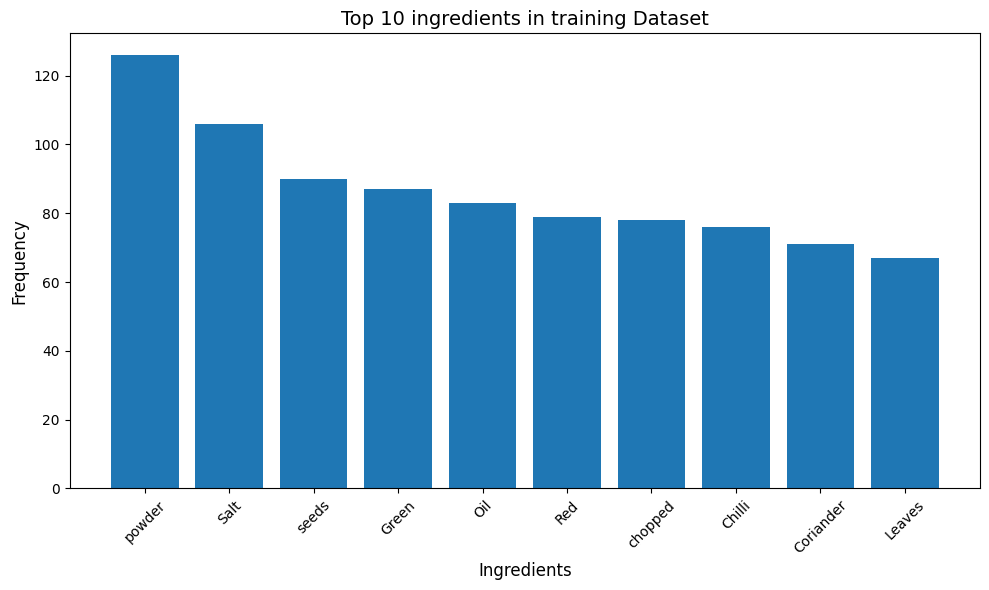

In [40]:
# plot the top frequent ingredients in training data
plot_top_items(ingredients, 'ingredient', 'training')

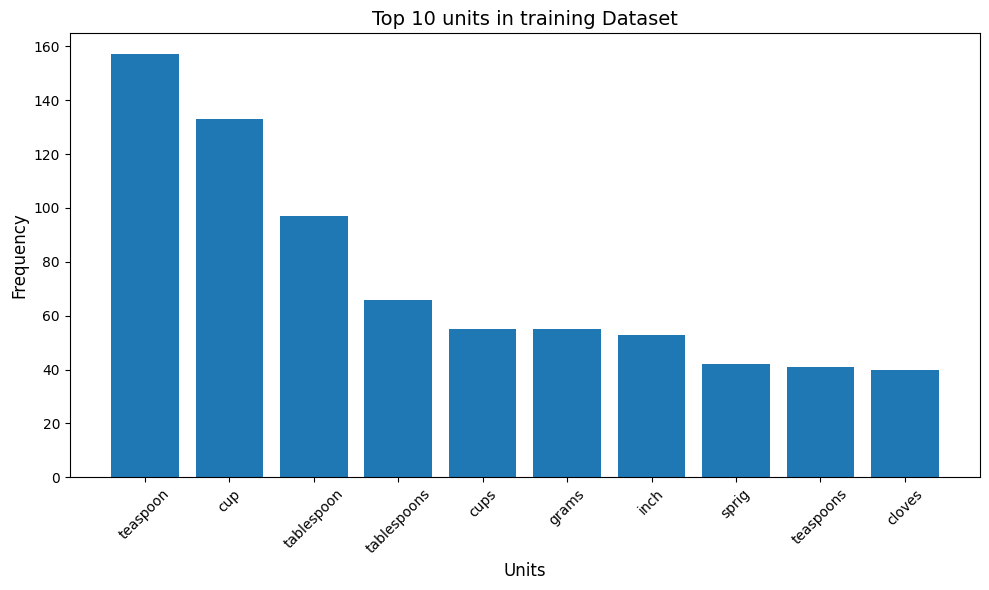

In [41]:
# plot the top frequent units in training data
plot_top_items(units, 'unit', 'training')

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [ ]:
# initialise the dataset_name


In [ ]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe


In [ ]:
# plot the top frequent ingredients in validation data


In [ ]:
# plot the top frequent units in training data


## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [42]:
# define unit and quantity keywords along with quantity pattern
import re
import spacy

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Unit-related keywords
unit_keywords = {
    'cup', 'cups', 'tablespoon', 'tablespoons', 'tbsp', 'teaspoon', 'teaspoons', 'tsp',
    'ml', 'l', 'liter', 'liters', 'grams', 'gram', 'g', 'kg', 'kgs', 'pound', 'oz', 'ounce'
}

# Quantity-related keywords
quantity_keywords = {
    'half', 'quarter', 'dozen', 'third', 'fourth', '1/2', '1/4', '3/4', 'two', 'three', 'four',
    'one', 'five', 'six', 'seven', 'eight', 'nine', 'ten'
}

# Regex pattern to capture numbers, decimals, and fractions
quantity_pattern = re.compile(r'^\d+([/-]\d+)?(\.\d+)?$|^\d+/\d+$|^\d+\.\d+$|^\d+$')



In [43]:
# load spaCy model
import spacy

# Load the small English model
nlp = spacy.load("en_core_web_sm")

##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [44]:
# define word2features for processing each token in the sentence sent by using index i.
def word2features(sent, i):
    word = sent[i]
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isdigit()': word.isdigit(),
        'word.istitle()': word.istitle(),
        'word.isupper()': word.isupper(),
        'word.isalpha()': word.isalpha(),
        'quantity_keyword': word.lower() in quantity_keywords,
        'unit_keyword': word.lower() in unit_keywords,
        'matches_quantity_pattern': bool(quantity_pattern.match(word)),
    }


# use your own feature functions

    # Process the entire sentence with spaCy

    # --- Core Features ---

    # --- Improved Quantity & Unit Detection ---

    # --- Contextual Features ---
        # Add spaCy POS and shape if available
    doc = nlp(word)
    if doc:
        token = doc[0]
        features['pos'] = token.pos_
        features['shape'] = token.shape_

    # Previous word features
    if i > 0:
        prev_word = sent[i - 1]
        features.update({
            '-1:word.lower()': prev_word.lower(),
            '-1:word.istitle()': prev_word.istitle(),
            '-1:word.isupper()': prev_word.isupper(),
        })
    else:
        features['BOS'] = True  # Beginning of sentence

    # Next word features
    if i < len(sent) - 1:
        next_word = sent[i + 1]
        features.update({
            '+1:word.lower()': next_word.lower(),
            '+1:word.istitle()': next_word.istitle(),
            '+1:word.isupper()': next_word.isupper(),
        })
    else:
        features['EOS'] = True  # End of sentence

    return features

### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [45]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
def sent2features(sentence):
    """
    Generate a list of feature dictionaries for each token in the sentence.

    Parameters:
        sentence (list): A list of tokens (words) from a recipe.

    Returns:
        list: A list of dictionaries, each containing features for one token.
    """
    return [word2features(sentence, i) for i in range(len(sentence))]

### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [46]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
# Convert training sentences into feature dictionaries
X_train_features = [sent2features(sentence) for sentence in X_train]

# Convert validation sentences into feature dictionaries
X_val_features = [sent2features(sentence) for sentence in X_val]


##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [47]:
# Convert labels into list as y_train_labels and y_val_labels
# Simply assign labels (already tokenized)
y_train_labels = y_train
y_val_labels = y_val


##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [48]:
# print the length of train features and labels
print("Length of X_train_features:", len(X_train_features))
print("Length of y_train_labels:", len(y_train_labels))

Length of X_train_features: 195
Length of y_train_labels: 195


In [49]:
# print the length of validation features and labels
print("Length of X_val_features:", len(X_val_features))
print("Length of y_val_labels:", len(y_val_labels))

Length of X_val_features: 84
Length of y_val_labels: 84


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [50]:
# Flatten labels in y_train
# Flatten nested list of labels in y_train
y_train_flat = [label for seq in y_train_labels for label in seq]

# Print length and a preview
print("Total labels in y_train_flat:", len(y_train_flat))
print("First 10 labels:", y_train_flat[:10])

Total labels in y_train_flat: 7009
First 10 labels: ['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'quantity']


##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [51]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts
from collections import Counter

# Count frequency of each label
label_counts = Counter(y_train_flat)

# Total number of labels
total_samples = sum(label_counts.values())

# Print results
print("Label Counts:", label_counts)
print("Total Samples:", total_samples)

Label Counts: Counter({'ingredient': 5229, 'quantity': 965, 'unit': 815})
Total Samples: 7009


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [52]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts
# Number of unique labels
num_classes = len(label_counts)

# Compute class weights
class_weights = {
    label: total_samples / (count * num_classes)
    for label, count in label_counts.items()
}

# Print results
print("Class Weights (Inverse Frequency):")
for label, weight in class_weights.items():
    print(f"{label}: {weight:.4f}")

Class Weights (Inverse Frequency):
quantity: 2.4211
unit: 2.8667
ingredient: 0.4468


In [53]:
# penalise ingredient label
# Make a copy of existing class weights
penalized_weights = class_weights.copy()

# Penalize 'ingredient' by reducing its weight further
penalized_weights['ingredient'] *= 0.5  # or any factor < 1

# Print updated weights
print("Penalized Class Weights:")
for label, weight in penalized_weights.items():
    print(f"{label}: {weight:.4f}")

Penalized Class Weights:
quantity: 2.4211
unit: 2.8667
ingredient: 0.2234


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [54]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)
def extract_features_with_class_weights(X, y, weight_dict):
    """
    Enrich each token's feature dict with a 'class_weight' based on its label.

    Parameters:
        X (list): List of sentences, where each sentence is a list of tokens.
        y (list): List of label sequences corresponding to X.
        weight_dict (dict): Dictionary mapping label to class weight.

    Returns:
        list: A list of sentences, where each sentence is a list of enriched feature dicts.
    """
    X_weighted = []

    for sentence, labels in zip(X, y):
        features = sent2features(sentence)
        for i in range(len(features)):
            label = labels[i]
            features[i]['class_weight'] = weight_dict.get(label, 1.0)  # Default to 1.0 if label not found
        X_weighted.append(features)

    return X_weighted

##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [55]:
# Apply manually computed class weights
# Apply class weights to extract weighted features for training set
X_train_weighted_features = extract_features_with_class_weights(X_train, y_train, penalized_weights)

# Apply class weights to extract weighted features for validation set
X_val_weighted_features = extract_features_with_class_weights(X_val, y_val, penalized_weights)

# Sanity check
print("Length of X_train_weighted_features:", len(X_train_weighted_features))
print("Length of X_val_weighted_features:", len(X_val_weighted_features))

Length of X_train_weighted_features: 195
Length of X_val_weighted_features: 84


## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [56]:
# initialise CRF model with the specified hyperparameters and use weight_dict

# train the CRF model with the weighted training data
from sklearn_crfsuite import CRF

# Initialise the CRF model with the given hyperparameters
crf_model = CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=1.0,
    max_iterations=100,
    all_possible_transitions=True
)

# Train the CRF model using the weighted features and training labels
crf_model.fit(X_train_weighted_features, y_train_labels)

print("CRF model training complete.")

CRF model training complete.


### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [57]:
# Evaluate the CRF Model on the training dataset
from sklearn_crfsuite import metrics

# Predict labels on the training data
y_train_pred = crf_model.predict(X_train_weighted_features)

# Evaluate using classification report
print("Classification Report on Training Set:")
print(metrics.flat_classification_report(y_pred=y_train_pred, y_true=y_train_labels))

Classification Report on Training Set:
              precision    recall  f1-score   support

  ingredient       1.00      1.00      1.00      5229
    quantity       1.00      0.99      1.00       965
        unit       0.99      1.00      1.00       815

    accuracy                           1.00      7009
   macro avg       1.00      1.00      1.00      7009
weighted avg       1.00      1.00      1.00      7009



In [58]:
# specify the flat classification report by using training data for evaluation
from sklearn_crfsuite import metrics

# Predict labels on training data
y_train_pred = crf_model.predict(X_train_weighted_features)

# Generate classification report
train_report = metrics.flat_classification_report(
    y_true=y_train_labels,
    y_pred=y_train_pred,
    labels=["quantity", "unit", "ingredient"],  # You can reorder or customize
    digits=4
)

# Print the report
print("Flat Classification Report on Training Data:\n")
print(train_report)

Flat Classification Report on Training Data:

              precision    recall  f1-score   support

    quantity     1.0000    0.9938    0.9969       965
        unit     0.9927    1.0000    0.9963       815
  ingredient     1.0000    1.0000    1.0000      5229

    accuracy                         0.9991      7009
   macro avg     0.9976    0.9979    0.9977      7009
weighted avg     0.9992    0.9991    0.9991      7009



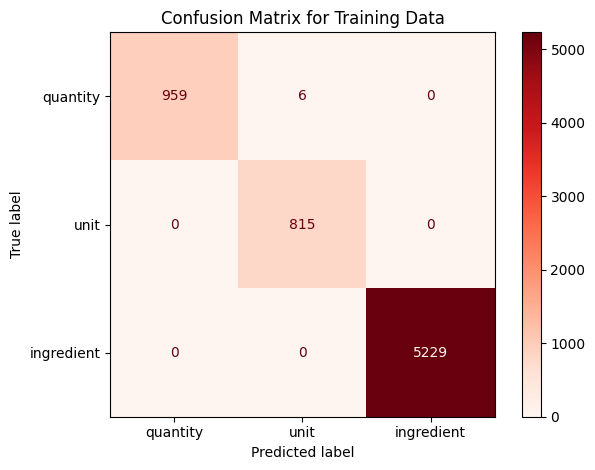

In [59]:
# create a confusion matrix on training datset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Flatten the lists of label sequences
y_train_true_flat = [label for seq in y_train_labels for label in seq]
y_train_pred_flat = [label for seq in y_train_pred for label in seq]

# Define label order
label_order = ["quantity", "unit", "ingredient"]

# Create confusion matrix
cm = confusion_matrix(y_train_true_flat, y_train_pred_flat, labels=label_order)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_order)
disp.plot(cmap=plt.cm.Reds, values_format='d')
plt.title("Confusion Matrix for Training Data")
plt.tight_layout()
plt.show()

### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [60]:
# dump the model using joblib as crf_model.pkl
import joblib

# Save the trained CRF model to a file
joblib.dump(crf_model, 'crf_model.pkl')

print("CRF model successfully saved as 'crf_model.pkl'")

CRF model successfully saved as 'crf_model.pkl'


## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [61]:
# predict the crf model on validation dataset
# Predict labels on the validation dataset
y_val_pred = crf_model.predict(X_val_weighted_features)

# Display the number of sequences predicted
print(f"Predicted {len(y_val_pred)} validation sequences.")

Predicted 84 validation sequences.


In [62]:
# specify flat classification report
from sklearn_crfsuite import metrics

# Generate classification report on validation data
val_report = metrics.flat_classification_report(
    y_true=y_val_labels,
    y_pred=y_val_pred,
    labels=["quantity", "unit", "ingredient"],  # Specify consistent label order
    digits=4
)

# Print the report
print("Flat Classification Report on Validation Data:\n")
print(val_report)

Flat Classification Report on Validation Data:

              precision    recall  f1-score   support

    quantity     0.9952    0.9928    0.9940       416
        unit     0.9914    0.9942    0.9928       347
  ingredient     1.0000    1.0000    1.0000      2146

    accuracy                         0.9983      2909
   macro avg     0.9955    0.9957    0.9956      2909
weighted avg     0.9983    0.9983    0.9983      2909



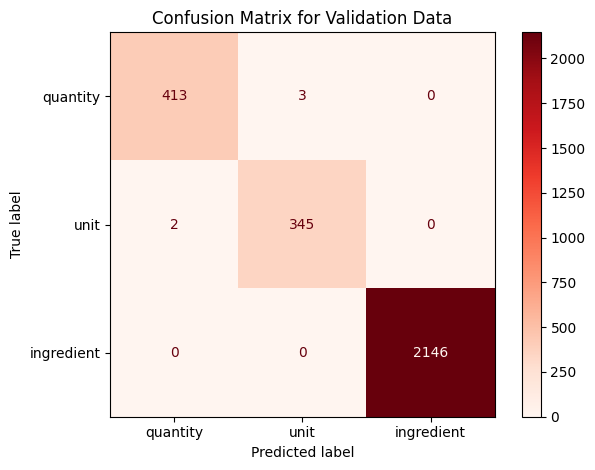

In [63]:
# create a confusion matrix on validation dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Flatten the predicted and true label sequences
y_val_true_flat = [label for seq in y_val_labels for label in seq]
y_val_pred_flat = [label for seq in y_val_pred for label in seq]

# Define label order for consistency
label_order = ["quantity", "unit", "ingredient"]

# Create confusion matrix
cm_val = confusion_matrix(y_val_true_flat, y_val_pred_flat, labels=label_order)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=label_order)
disp.plot(cmap=plt.cm.Reds, values_format='d')
plt.title("Confusion Matrix for Validation Data")
plt.tight_layout()
plt.show()

## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [64]:
# flatten Labels and Initialise Error Data
# Flatten true and predicted validation labels
y_val_true_flat = [label for seq in y_val_labels for label in seq]
y_val_pred_flat = [label for seq in y_val_pred for label in seq]

# Initialize error data: list of (true_label, predicted_label) where there's a mismatch
error_data = [
    (true, pred) for true, pred in zip(y_val_true_flat, y_val_pred_flat) if true != pred
]

# Print results
print(f"Total validation samples: {len(y_val_true_flat)}")
print(f"Total errors found: {len(error_data)}")
print("First 5 errors:", error_data[:5])

Total validation samples: 2909
Total errors found: 5
First 5 errors: [('quantity', 'unit'), ('quantity', 'unit'), ('quantity', 'unit'), ('unit', 'quantity'), ('unit', 'quantity')]


##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [65]:
# iterate and collect Error Information

            # get previous and next tokens with handling for boundary cases
# Initialize error data list
detailed_error_data = []

# Iterate over each sentence and its predictions
for sentence_tokens, true_labels, pred_labels in zip(X_val, y_val_labels, y_val_pred):
    for i in range(len(sentence_tokens)):
        token = sentence_tokens[i]
        true_label = true_labels[i]
        pred_label = pred_labels[i]

        # Only collect if there's a misclassification
        if true_label != pred_label:
            # Previous token (if not at beginning)
            prev_token = sentence_tokens[i - 1] if i > 0 else "BOS"

            # Next token (if not at end)
            next_token = sentence_tokens[i + 1] if i < len(sentence_tokens) - 1 else "EOS"

            # Class weight (from penalized_weights)
            class_weight = penalized_weights.get(true_label, 1.0)

            # Append error info
            detailed_error_data.append({
                "token": token,
                "true_label": true_label,
                "predicted_label": pred_label,
                "prev_token": prev_token,
                "next_token": next_token,
                "class_weight": class_weight
            })

# Print total errors and a few samples
print(f"Total errors collected: {len(detailed_error_data)}")
print("Sample error details:")
for err in detailed_error_data[:5]:
    print(err)

Total errors collected: 5
Sample error details:
{'token': 'for', 'true_label': 'quantity', 'predicted_label': 'unit', 'prev_token': 'Oil', 'next_token': 'kneading', 'class_weight': 2.4210708117443867}
{'token': 'Little', 'true_label': 'quantity', 'predicted_label': 'unit', 'prev_token': 'meat', 'next_token': 'extra', 'class_weight': 2.4210708117443867}
{'token': 'for', 'true_label': 'quantity', 'predicted_label': 'unit', 'prev_token': 'Honey', 'next_token': 'glazing', 'class_weight': 2.4210708117443867}
{'token': 'a', 'true_label': 'unit', 'predicted_label': 'quantity', 'prev_token': 'Haldi', 'next_token': 'pinch', 'class_weight': 2.8666666666666667}
{'token': 'to', 'true_label': 'unit', 'predicted_label': 'quantity', 'prev_token': '10', 'next_token': '12', 'class_weight': 2.8666666666666667}


##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [66]:
# Create DataFrame and Print Overall Accuracy
import pandas as pd

# Step 1: Create DataFrame from error details
error_df = pd.DataFrame(detailed_error_data)

# Step 2: Calculate total number of tokens in validation data
total_val_tokens = sum(len(seq) for seq in y_val_labels)

# Step 3: Calculate total number of errors
num_errors = len(error_df)

# Step 4: Compute accuracy
accuracy = (total_val_tokens - num_errors) / total_val_tokens

# Step 5: Output
print("Validation Error DataFrame:")
print(error_df.head())

print(f"\n Overall Accuracy on Validation Data: {accuracy:.4f}")

Validation Error DataFrame:
    token true_label predicted_label prev_token next_token  class_weight
0     for   quantity            unit        Oil   kneading      2.421071
1  Little   quantity            unit       meat      extra      2.421071
2     for   quantity            unit      Honey    glazing      2.421071
3       a       unit        quantity      Haldi      pinch      2.866667
4      to       unit        quantity         10         12      2.866667

 Overall Accuracy on Validation Data: 0.9983


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [67]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context
# Count errors by true label
error_by_label = error_df['true_label'].value_counts().to_dict()

# Total tokens per label in validation set
from collections import Counter

# Flatten true labels from validation set
y_val_flat = [label for seq in y_val_labels for label in seq]
val_label_counts = Counter(y_val_flat)

# Compute per-label accuracy and show class weights
print("Error Analysis by Label:\n")
print(f"{'Label':<12}{'Errors':<10}{'Total':<10}{'Accuracy':<12}{'Class Weight'}")
print("-" * 55)

for label in val_label_counts:
    total = val_label_counts[label]
    errors = error_by_label.get(label, 0)
    acc = (total - errors) / total
    weight = penalized_weights.get(label, 1.0)
    print(f"{label:<12}{errors:<10}{total:<10}{acc:<12.4f}{weight:.4f}")


Error Analysis by Label:

Label       Errors    Total     Accuracy    Class Weight
-------------------------------------------------------
quantity    3         416       0.9928      2.4211
unit        2         347       0.9942      2.8667
ingredient  0         2146      1.0000      0.2234


### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




*italicized text* <font color = red>[Write your answer]</font>

 #### Key observations
- Ingredient Predictions Are Perfect
    - The model achieved 100% accuracy for the ingredient label with zero errors.
    - However, its low class weight (0.2234) indicates it’s the most frequent label in the dataset, which might suggest model bias or overfitting for this class.
- Slight Errors in Quantity and Unit
    - The model made only 3 errors in predicting quantity and 2 errors in unit.
    - Despite their lower frequency, their class weights (2.42 and 2.87) helped the model learn to prioritize them.
    - These results confirm that the class weighting strategy was effective in addressing class imbalance.
-  Strong Overall Generalization
    - With all classes achieving over 99% accuracy, the model demonstrates excellent performance and generalization on the validation set.

#### Recommendations:
- Consider cross-validation for deeper model's robustness analysis.
- Use real-world or augmented data to boost under-represented classes like unit and quantity.
- Keep monitoring performance when scaling to new recipes or languages.

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.